# Import data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, roc_auc_score, cohen_kappa_score
from sklearn.ensemble import BaggingClassifier
from sklearn import linear_model
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
import seaborn as sns 

import itertools


In [2]:
plt.rcParams['figure.figsize'] = [3, 3]
plt.rcParams['figure.dpi'] = 300

loc = {3: "GO", 4: "CL", 5: "SC", 6: "MA"}
loc_name = ["GO", "CL", "SC", "MA"]


def df2Xy(df):
    n_data, n_features = len(df), len(df.T)
    X = np.array(df.iloc[:, 2:(n_features)])  # inputs
    #X = np.where(X>0,1,0) # trasform data into presence-absence of the species
    y = np.array(df.iloc[:, 1], int)  # labels
    return X, y, df.columns[2:]

def plot_feature_importance(importance,names,showcategories,model_type, file_name=""):
    '''This function plots the n more important categories defined by the model in the fitting phase. It also saves a .csv file with the taxonomy associated with each OTU and its importance in the model.'''

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
#    #Merge with taxonomy database of names:
#    fi_df = pd.merge(fi_df, names.to_frame(), left_on='feature_names', right_on='OTU_ID')
#    #Concatenate OTU_ID with taxonomy:
#    fi_df['combined'] = fi_df['OTU_ID'].astype(str)+" | "+fi_df['Taxon']

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Export to csv:
    fi_df.to_csv(file_name+".csv")
    
    #Keep only n top categories:
    fi_df = fi_df.head(n=showcategories)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.tight_layout()
    plt.savefig(file_name+".pdf")

def get_coeff_linear_bagging(lbe, otuid,file_name=""):
    ''' You should obtain a matrix with n_classes and features. Features will be mediated over all predictors. Highly positive or negative coefficients will give the most relevant features for each class. 
    Example usage: w = get_coeff_linear_bagging(clf_br)'''
    w = np.zeros((lbe.n_classes_,lbe.n_features_)) #Empty array. N righe X N colonne.
    for i,m in enumerate(lbe.estimators_):
        idx = lbe.estimators_features_[i]
        w[:,idx] += m.coef_/lbe.n_estimators
    #Export as .csv:
    fi = pd.DataFrame(w)
    fiTran = fi.T #Transpose df
    otu = otuid #Add otu ids:
    fiTran["OTU"] = otu
    
    fiTran.to_csv(file_name+".csv")
    return w


def plot_cm(cm,
            classes,
            normalize=False,
            title='Confusion matrix',
            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,
                 i,
                 cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# Load datasets:

####### Gills:
df_S18_br = pd.read_csv(
    "Feature-table_Postdepuration_tissue_br-E18_FilterThreshold0.05_binary.csv",
    sep=",")
df_S19_br = pd.read_csv(
    "Feature-table_Postdepuration_tissue_br-E19_FilterThreshold0.05_binary.csv",
    sep=",")

df_W19_br = pd.read_csv(
    "Feature-table_Postdepuration_tissue_br-I19_FilterThreshold0.05_binary_noCR.csv",
    sep=",")
df_W20_br = pd.read_csv(
    "Feature-table_Postdepuration_tissue_br-I20_FilterThreshold0.05_binary_noCR.csv",
    sep=",")

df_W19_br = df_W19_br[df_W19_br.Classe != 7]
df_W20_br = df_W20_br[df_W20_br.Classe != 7]

# Take unions
df_V_br = df_S18_br.append(df_W19_br, ignore_index=True, sort=False).fillna(0)
df_L_br = df_S19_br.append(df_W20_br, ignore_index=True, sort=False).fillna(0)

######## Hepatopancreas:
df_S18_gh = pd.read_csv(
    "Feature-table_Postdepuration_tissue_gh-E18_FilterThreshold0.05_binary.csv",
    sep=",")
df_S19_gh = pd.read_csv(
    "Feature-table_Postdepuration_tissue_gh-E19_FilterThreshold0.05_binary.csv",
    sep=",")

df_W19_gh = pd.read_csv(
    "Feature-table_Postdepuration_tissue_gh-I19_FilterThreshold0.05_binary_noCR.csv",
    sep=",")
df_W20_gh = pd.read_csv(
    "Feature-table_Postdepuration_tissue_gh-I20_FilterThreshold0.05_binary_noCR.csv",
    sep=",")

df_W19_gh = df_W19_gh[df_W19_gh.Classe != 7]
df_W20_gh = df_W20_gh[df_W20_gh.Classe != 7]

# Take unions
df_V_gh = df_S18_gh.append(df_W19_gh, ignore_index=True, sort=False).fillna(0)
df_L_gh = df_S19_gh.append(df_W20_gh, ignore_index=True, sort=False).fillna(0)

########## Make train and test
XL_br, yL_br, otu_names_br = df2Xy(df_L_br)
XV_br, yV_br, otu_names_br = df2Xy(df_V_br)
print("branchie - dimensioni dataframes: ", df_L_br.shape, df_V_br.shape, XL_br.shape, XV_br.shape, otu_names_br.shape)

XL_gh, yL_gh, otu_names_gh = df2Xy(df_L_gh)
XV_gh, yV_gh, otu_names_gh = df2Xy(df_V_gh)
print("ghiandola digestiva - dimensioni dataframes: ", df_L_gh.shape,
      df_V_gh.shape, otu_names_gh.shape)

branchie - dimensioni dataframes:  (40, 346) (40, 346) (40, 344) (40, 344) (344,)
ghiandola digestiva - dimensioni dataframes:  (40, 315) (40, 315) (313,)


/var/folders/2r/_gg4h4nn1tl6n9_6p06blhbh0000gn/T/ipykernel_36517/67856111.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_V_br = df_S18_br.append(df_W19_br, ignore_index=True, sort=False).fillna(0)
/var/folders/2r/_gg4h4nn1tl6n9_6p06blhbh0000gn/T/ipykernel_36517/67856111.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_L_br = df_S19_br.append(df_W20_br, ignore_index=True, sort=False).fillna(0)
/var/folders/2r/_gg4h4nn1tl6n9_6p06blhbh0000gn/T/ipykernel_36517/67856111.py:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_V_gh = df_S18_gh.append(df_W19_gh, ignore_index=True, sort=False).fillna(0)
/var/folders/2r/_gg4h4nn1tl6n9_6p06blhbh0000gn/T/ipykernel_36517/67856111.py:45: FutureWarning: The frame.append me

# Start cross-validation on second year data

## Gills:

param= estimators: 500 max features: 100

K-score= 0.6333333333333333 
##########
param= estimators: 1000 max features: 100

K-score= 0.6666666666666667 
##########
param= estimators: 1500 max features: 100

K-score= 0.6666666666666667 
##########
param= estimators: 500 max features: 200

K-score= 0.7 
##########
param= estimators: 1000 max features: 200

K-score= 0.7 
##########
param= estimators: 1500 max features: 200

K-score= 0.7 
##########
param= estimators: 500 max features: 300

K-score= 0.7 
##########
param= estimators: 1000 max features: 300

K-score= 0.7 
##########
param= estimators: 1500 max features: 300

K-score= 0.7 
##########
best= (1500, 300)
>>>               precision    recall  f1-score   support

           3       0.71      1.00      0.83        10
           4       0.67      0.80      0.73        10
           5       0.80      0.40      0.53        10
           6       1.00      0.90      0.95        10

    accuracy                           0.78        4

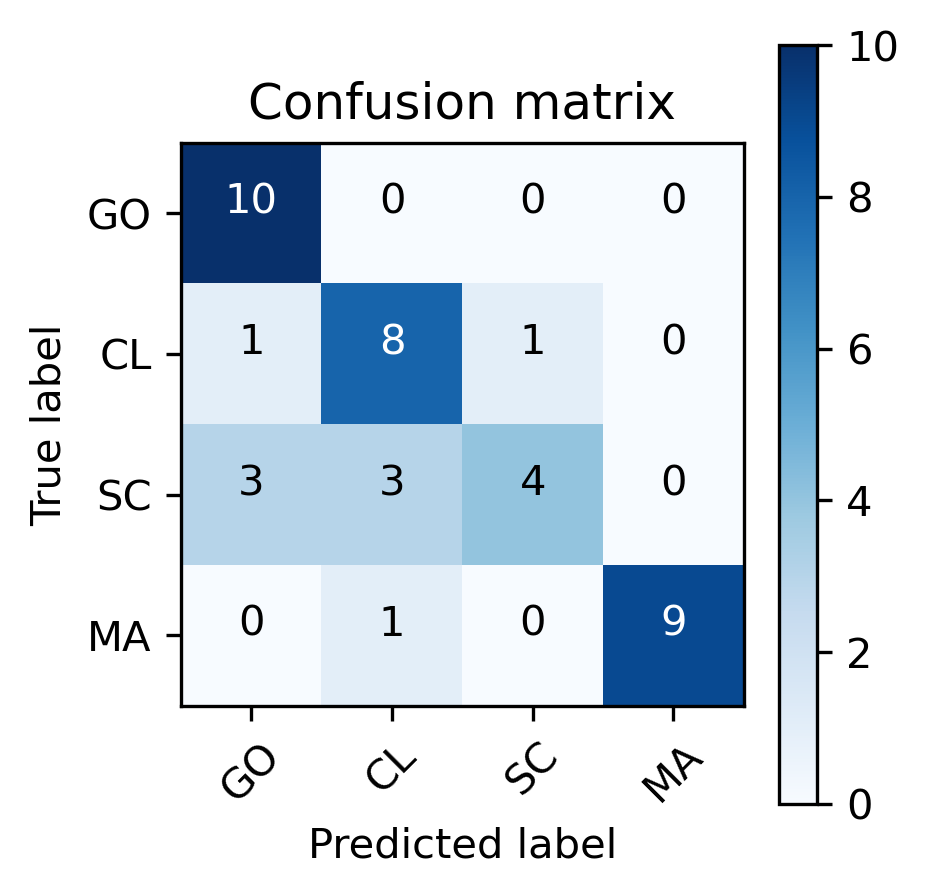

best= (1500, 300)


In [4]:
# Parameters:
X_br, y_br = XL_br, yL_br 
cv_br = KFold(n_splits=10)
bscore_br= -1
abest_br=0.1
ne_br = 1000 # to be tested
cval_br = 1.0
ms_br = 60 # to be tested
bobs_br, bpred_br = [], []

# Model:
model_br = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=cval_br, class_weight="balanced", max_iter=1000, fit_intercept=False)

for mf in [100, 200, 300]:
    for ne_br in [500, 1000, 1500]:
        print("param= estimators:", ne_br, "max features:", mf)
        clf_br = BaggingClassifier(base_estimator=model_br , n_estimators=ne_br, max_features=mf)
        pred_br, pred_prob_br, obs_br =[], [], []
        for train_index, test_index in cv_br.split(X_br):
                #print("TRAIN:", train_index, ",TEST:", test_index)
                X_train, X_test = X_br[train_index], X_br[test_index]
                y_train, y_test = y_br[train_index], y_br[test_index]
                clf_br.fit(X_train, y_train)
                pred_br.extend(clf_br.predict(X_test))
                obs_br.extend(y_test)
        score_br = cohen_kappa_score(obs_br,pred_br)
        if score_br >= bscore_br:
                bscore_br = score_br
                abest_br = ne_br,mf #Uncomment for ne_br optimisation
                #abest_br = mf
                bobs_br = obs_br[:]
                bpred_br = pred_br[:]
        print("\nK-score=",cohen_kappa_score(obs_br,pred_br),"\n"+"#"*10) 

print("best=",abest_br)

# Assess the goodness of the chosen parameters:
print(">>>",classification_report(bobs_br,bpred_br),
          "\nK-score=",cohen_kappa_score(bobs_br,bpred_br),
          "\n"+"#"*10)
cnf_matrix = confusion_matrix(bobs_br, bpred_br)
plot_cm(cnf_matrix, classes=loc_name)
plt.show()        
print("best=",abest_br)

## Digestive gland:

param= estimators: 500 max features: 100

K-score= 0.5666666666666667 
##########
param= estimators: 1000 max features: 100

K-score= 0.6 
##########
param= estimators: 1500 max features: 100

K-score= 0.5666666666666667 
##########
param= estimators: 500 max features: 200

K-score= 0.6666666666666667 
##########
param= estimators: 1000 max features: 200

K-score= 0.7 
##########
param= estimators: 1500 max features: 200

K-score= 0.6666666666666667 
##########
param= estimators: 500 max features: 300

K-score= 0.7 
##########
param= estimators: 1000 max features: 300

K-score= 0.7 
##########
param= estimators: 1500 max features: 300

K-score= 0.7 
##########
best= (1500, 300)
>>>               precision    recall  f1-score   support

           3       0.82      0.90      0.86        10
           4       0.64      0.70      0.67        10
           5       0.71      0.50      0.59        10
           6       0.91      1.00      0.95        10

    accuracy                         

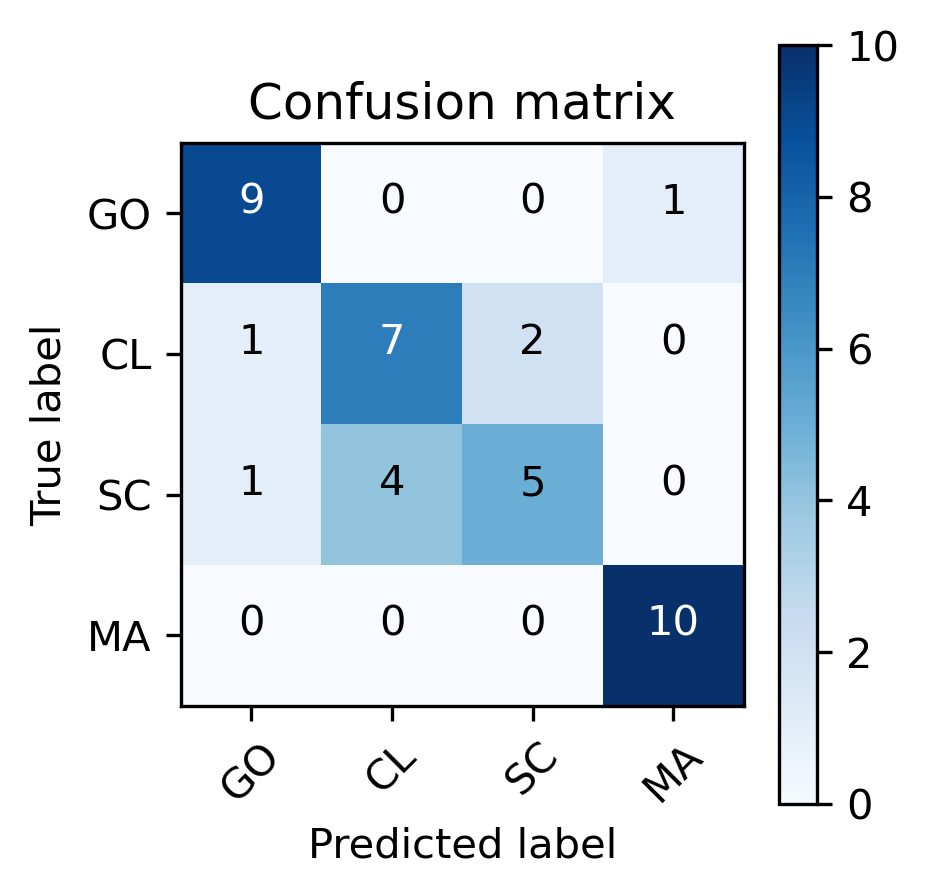

best= (1500, 300)


In [5]:
# Parameters:
X_gh, y_gh = XL_gh, yL_gh 
cv_gh = KFold(n_splits=10)
bscore_gh= -1
abest_gh=0.1
ne_gh = 1000 # to be tested
cval_gh = 1.0
ms_gh = 60 # to be tested
bobs_gh, bpred_gh = [], []

# Model:
model_gh = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=cval_gh, class_weight="balanced", max_iter=1000, fit_intercept=False)

for mf in [100, 200, 300]:
    for ne_gh in [500, 1000, 1500]:
        print("param= estimators:", ne_gh, "max features:", mf)
        clf_gh = BaggingClassifier(base_estimator=model_gh , n_estimators=ne_gh, max_features=mf)
        pred_gh, pred_prob_gh, obs_gh =[], [], []
        for train_index, test_index in cv_gh.split(X_gh):
                #print("TRAIN:", train_index, ",TEST:", test_index)
                X_train, X_test = X_gh[train_index], X_gh[test_index]
                y_train, y_test = y_gh[train_index], y_gh[test_index]
                clf_gh.fit(X_train, y_train)
                pred_gh.extend(clf_gh.predict(X_test))
                obs_gh.extend(y_test)
        score_gh = cohen_kappa_score(obs_gh,pred_gh)
        if score_gh >= bscore_gh:
                bscore_gh = score_gh
                abest_gh = ne_gh,mf #Uncomment for ne_gh optimisation
                #abest_gh = mf
                bobs_gh = obs_gh[:]
                bpred_gh = pred_gh[:]
        print("\nK-score=",cohen_kappa_score(obs_gh,pred_gh),"\n"+"#"*10) 

print("best=",abest_gh)

# Assess the goodness of the chosen parameters:
print(">>>",classification_report(bobs_gh,bpred_gh),
          "\nK-score=",cohen_kappa_score(bobs_gh,bpred_gh),
          "\n"+"#"*10)
cnf_matrix = confusion_matrix(bobs_gh, bpred_gh)
plot_cm(cnf_matrix, classes=loc_name)
plt.show()        
print("best=",abest_gh)

--------------------------------------------------------------
# Fit on second year data and predict first year

## Gills:

 All sets
>>> Xs19               precision    recall  f1-score   support

           3       0.57      0.40      0.47        10
           4       0.59      1.00      0.74        10
           5       0.50      0.50      0.50        10
           6       1.00      0.60      0.75        10

    accuracy                           0.62        40
   macro avg       0.66      0.62      0.62        40
weighted avg       0.66      0.62      0.62        40
 
K-score= 0.5 
##########


/Users/luca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


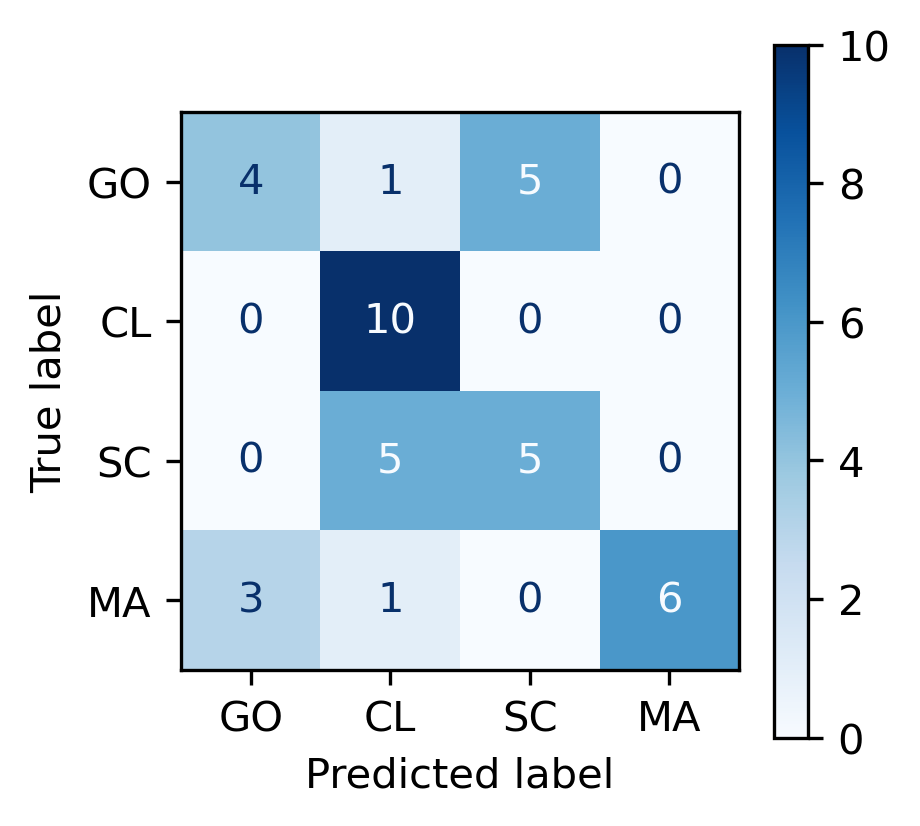

In [6]:
ne_br, mf_br = abest_br # best paramenters

clf_br = clf_br = BaggingClassifier(base_estimator=model_br , n_estimators=ne_br, max_features=mf_br)
np.random.seed(42)
clf_br.fit(XL_br,yL_br)

print ("="*20,"\n","All sets\n","="*20) 
p_br = clf_br.predict_proba(XV_br) 
pred_br = clf_br.predict(XV_br)
print(">>> Xs19",classification_report(yV_br,pred_br),
          "\nK-score=",cohen_kappa_score(yV_br,pred_br),
          "\n"+"#"*10)
#from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

#plt.figure()
plot_confusion_matrix(clf_br, XV_br, yV_br,display_labels=loc_name, cmap=plt.cm.Blues, normalize=None)
plt.show()

### Get Feature Importances:

In [7]:
wY1Br = get_coeff_linear_bagging(clf_br,otu_names_br,file_name="FeatureImportance_BR_firstYear", )

/Users/luca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## Digestive gland:

 All sets
>>> Xs19               precision    recall  f1-score   support

           3       0.89      0.80      0.84        10
           4       0.73      0.80      0.76        10
           5       0.80      0.80      0.80        10
           6       0.90      0.90      0.90        10

    accuracy                           0.82        40
   macro avg       0.83      0.83      0.83        40
weighted avg       0.83      0.82      0.83        40
 
K-score= 0.7666666666666666 
##########


/Users/luca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


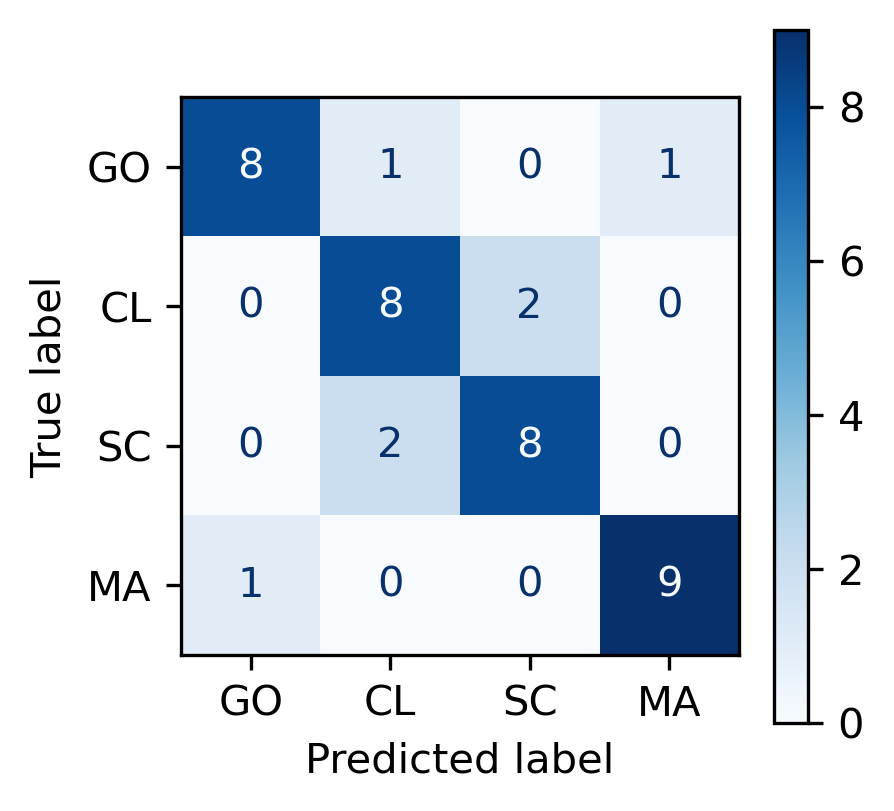

In [8]:
ne_gh, mf_gh = abest_gh # best paramenters

clf_gh = clf_gh = BaggingClassifier(base_estimator=model_gh , n_estimators=ne_gh, max_features=mf_gh)
np.random.seed(42)
clf_gh.fit(XL_gh,yL_gh)

print ("="*20,"\n","All sets\n","="*20) 
p_gh = clf_gh.predict_proba(XV_gh) 
pred_gh = clf_gh.predict(XV_gh)
print(">>> Xs19",classification_report(yV_gh,pred_gh),
          "\nK-score=",cohen_kappa_score(yV_gh,pred_gh),
          "\n"+"#"*10)
#from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

#plt.figure()
plot_confusion_matrix(clf_gh, XV_gh, yV_gh,display_labels=loc_name, cmap=plt.cm.Blues, normalize=None)
plt.show()

### Get Feature Importances:

In [9]:
wY1Br = get_coeff_linear_bagging(clf_gh,otu_names_gh,file_name="FeatureImportance_HEP_firstYear", )

/Users/luca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## Sum probabilities to obtain one consensus prediction:

Prediction branchie: [4 4 4 4 4 5 3 3 3 5 6 3 4 6 6 5 5 5 5 4 4 4 4 4 4 4 5 5 5 3 6 6 6 3 3 4 4
 5 4 4]

Prediction ghiandola: [4 4 4 4 5 4 3 3 3 3 6 6 6 6 6 5 4 4 5 5 4 5 4 4 4 3 3 3 6 3 6 3 6 6 6 5 5
 5 5 5]

Prediction global: [4 4 4 4 5 5 3 3 3 3 6 6 6 6 6 5 5 5 5 5 4 4 4 4 4 3 3 3 5 3 6 3 6 3 6 5 5
 5 4 4]

 ##################################################

branchie:  [4 4 4 4 4 3 3 3 3 3 6 6 6 6 6 5 5 5 5 5 4 4 4 4 4 3 3 3 3 3 6 6 6 6 6 5 5
 5 5 5]

ghiandola:  [4 4 4 4 4 3 3 3 3 3 6 6 6 6 6 5 5 5 5 5 4 4 4 4 4 3 3 3 3 3 6 6 6 6 6 5 5
 5 5 5]
>>> Xs18               precision    recall  f1-score   support

           3       0.80      0.80      0.80        10
           4       0.82      0.90      0.86        10
           5       0.73      0.80      0.76        10
           6       1.00      0.80      0.89        10

    accuracy                           0.82        40
   macro avg       0.84      0.82      0.83        40
weighted avg       0.84      0.82      0.83        40


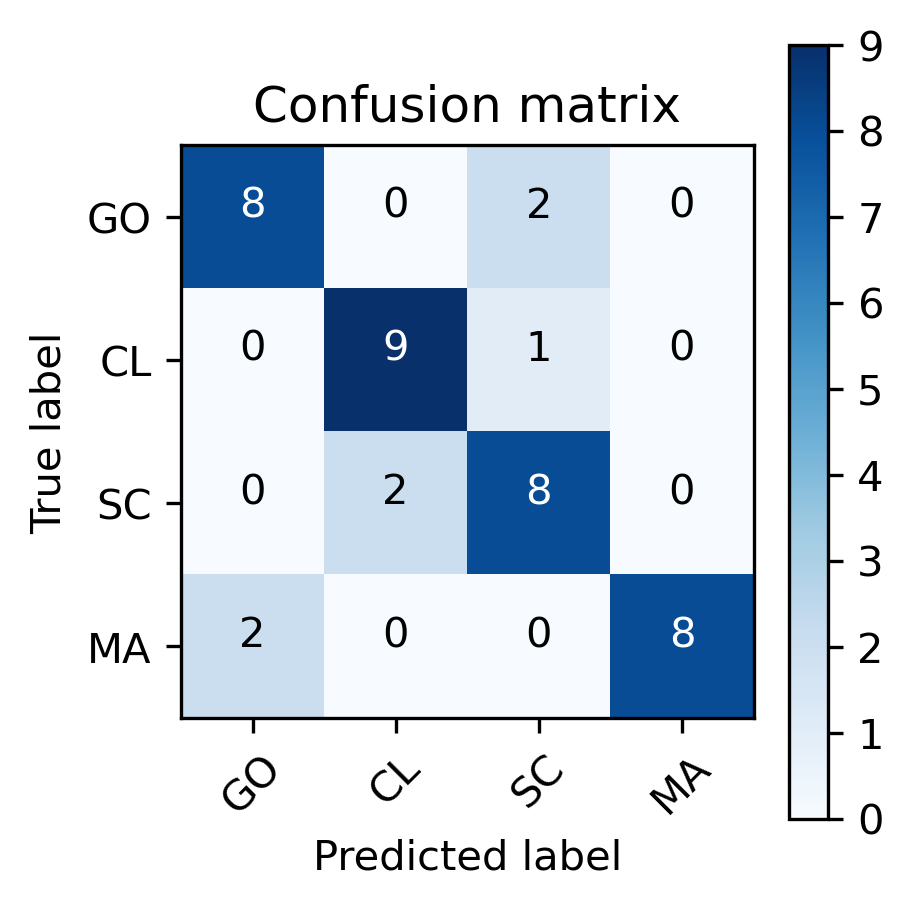

In [10]:
p_global = np.argmax(p_gh + p_br, axis=1)+3
print("Prediction branchie:", np.argmax(p_br, axis=1)+3)
print("\nPrediction ghiandola:", np.argmax(p_gh, axis=1)+3)
print("\nPrediction global:",p_global)
print("\n", "#"*50)

# True labels are:
print("\nbranchie: ", yV_br)
print("\nghiandola: ", yV_gh)

# Confusion matrix of global prediction:
print(">>> Xs18",classification_report(yV_br,p_global),
          "\nK-score=",cohen_kappa_score(yV_br,p_global),
          "\n"+"#"*10)
cnf_matrix = confusion_matrix(yV_br, p_global)
cfm_plot = plot_cm(cnf_matrix, classes=loc_name)


--------------------------------------------------------------
# Fit on first year data and predict second year data

## Gills:

 All sets
>>> Xs18               precision    recall  f1-score   support

           3       0.50      0.30      0.37        10
           4       0.82      0.90      0.86        10
           5       0.80      0.40      0.53        10
           6       0.44      0.80      0.57        10

    accuracy                           0.60        40
   macro avg       0.64      0.60      0.58        40
weighted avg       0.64      0.60      0.58        40
 
K-score= 0.4666666666666667 
##########


/Users/luca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


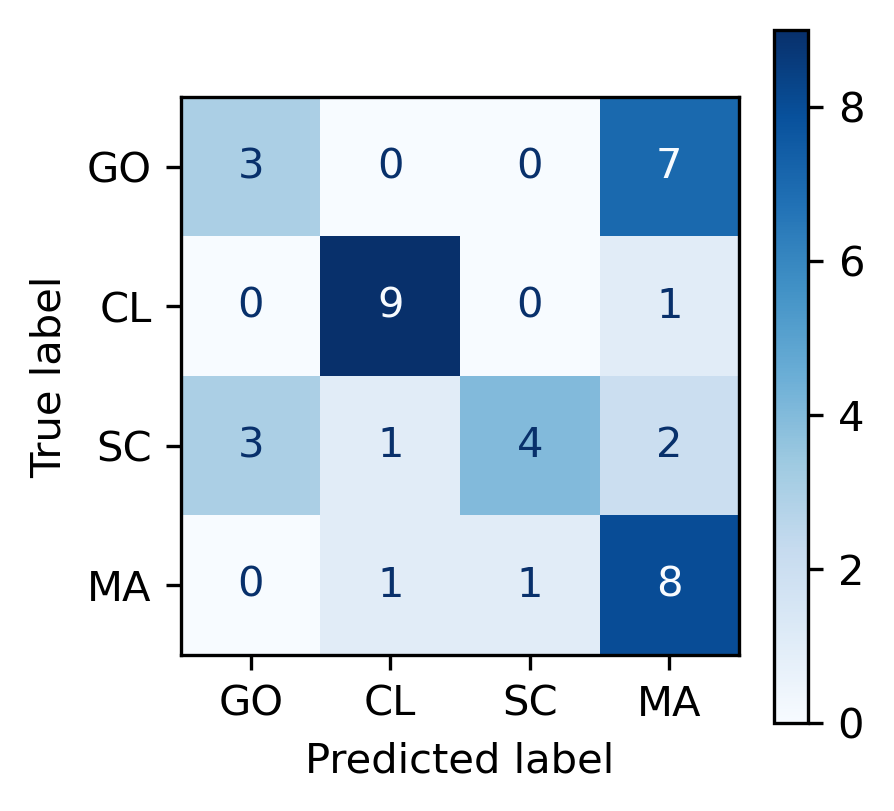

In [11]:
ne_br,mf_br = abest_br 

clf_br = clf_br = BaggingClassifier(base_estimator=model_br , n_estimators=ne_br, max_features=mf_br)
np.random.seed(42)
clf_br.fit(XV_br,yV_br)

print ("="*20,"\n","All sets\n","="*20) 
p_br = clf_br.predict_proba(XL_br) 
pred_br = clf_br.predict(XL_br)
print(">>> Xs18",classification_report(yL_br,pred_br),
          "\nK-score=",cohen_kappa_score(yL_br,pred_br),
          "\n"+"#"*10)
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(clf_br, XL_br, yL_br,display_labels=loc_name, cmap=plt.cm.Blues, normalize=None)
plt.show()


### Get Feature Importances:

In [12]:
wY1Br = get_coeff_linear_bagging(clf_br,otu_names_br,file_name="FeatureImportance_BR_secondYear", )

/Users/luca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## Digestive gland:

 All sets
>>> Xs18               precision    recall  f1-score   support

           3       0.80      0.80      0.80        10
           4       0.91      1.00      0.95        10
           5       1.00      0.80      0.89        10
           6       0.82      0.90      0.86        10

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40
 
K-score= 0.8333333333333334 
##########


/Users/luca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


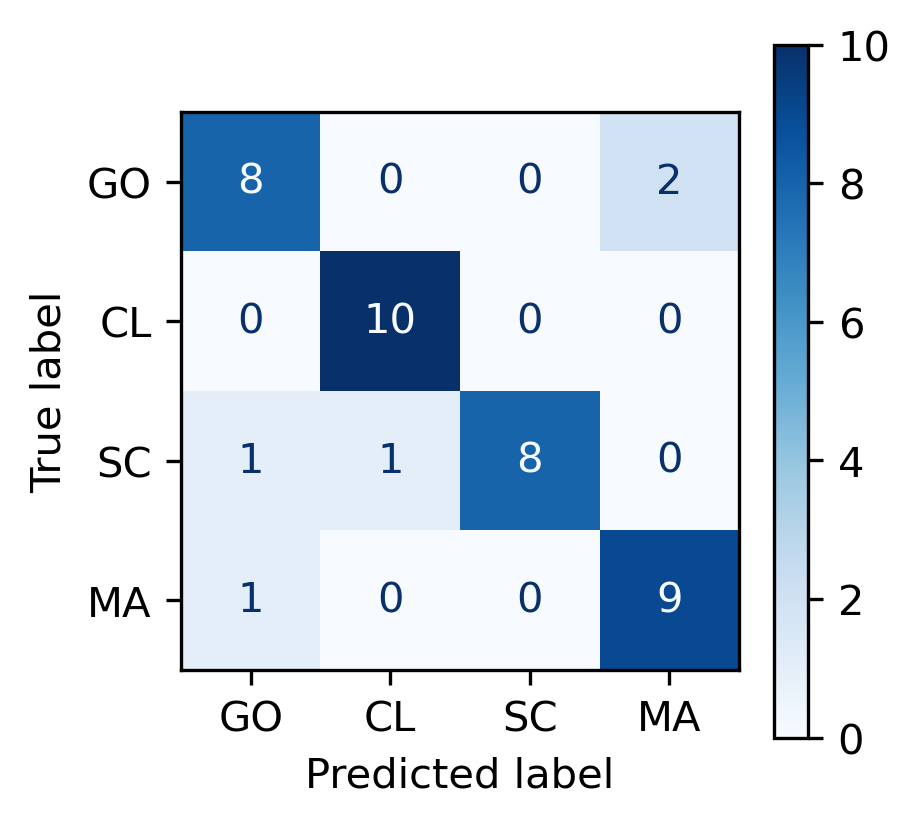

In [13]:
ne_gh,mf_gh = abest_gh 

clf_gh = clf_gh = BaggingClassifier(base_estimator=model_gh , n_estimators=ne_gh, max_features=mf_gh)
np.random.seed(42)
clf_gh.fit(XV_gh,yV_gh)

print ("="*20,"\n","All sets\n","="*20) 
p_gh = clf_gh.predict_proba(XL_gh) 
pred_gh = clf_gh.predict(XL_gh)
print(">>> Xs18",classification_report(yL_gh,pred_gh),
          "\nK-score=",cohen_kappa_score(yL_gh,pred_gh),
          "\n"+"#"*10)
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(clf_gh, XL_gh, yL_gh,display_labels=loc_name, cmap=plt.cm.Blues, normalize=None)
plt.show()

### Get Feature Importances:

In [14]:
wY1Br = get_coeff_linear_bagging(clf_gh,otu_names_gh,file_name="FeatureImportance_HEP_secondYear", )

/Users/luca/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `n_features_` was deprecated in version 1.0 and will be removed in 1.2. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)


## Sum probabilities to obtain one consensus prediction:

Prediction branchie: [4 4 4 4 6 3 6 3 6 6 6 6 6 6 6 5 6 3 6 3 4 4 4 4 4 6 6 6 3 6 4 6 6 5 6 3 4
 5 5 5]

Prediction ghiandola: [4 4 4 4 4 6 3 3 3 3 6 6 6 6 6 5 5 5 5 5 4 4 4 4 4 6 3 3 3 3 3 6 6 6 6 5 4
 5 3 5]

Prediction global: [4 4 4 4 4 6 3 3 3 6 6 6 6 6 6 5 5 3 5 6 4 4 4 4 4 6 6 3 3 3 4 6 6 6 6 5 4
 5 3 5]

 ##################################################

branchie:  [4 4 4 4 4 3 3 3 3 3 6 6 6 6 6 5 5 5 5 5 4 4 4 4 4 3 3 3 3 3 6 6 6 6 6 5 5
 5 5 5]

ghiandola:  [4 4 4 4 4 3 3 3 3 3 6 6 6 6 6 5 5 5 5 5 4 4 4 4 4 3 3 3 3 3 6 6 6 6 6 5 5
 5 5 5]
>>> Xs18               precision    recall  f1-score   support

           3       0.75      0.60      0.67        10
           4       0.83      1.00      0.91        10
           5       1.00      0.60      0.75        10
           6       0.64      0.90      0.75        10

    accuracy                           0.78        40
   macro avg       0.81      0.78      0.77        40
weighted avg       0.81      0.78      0.77        40


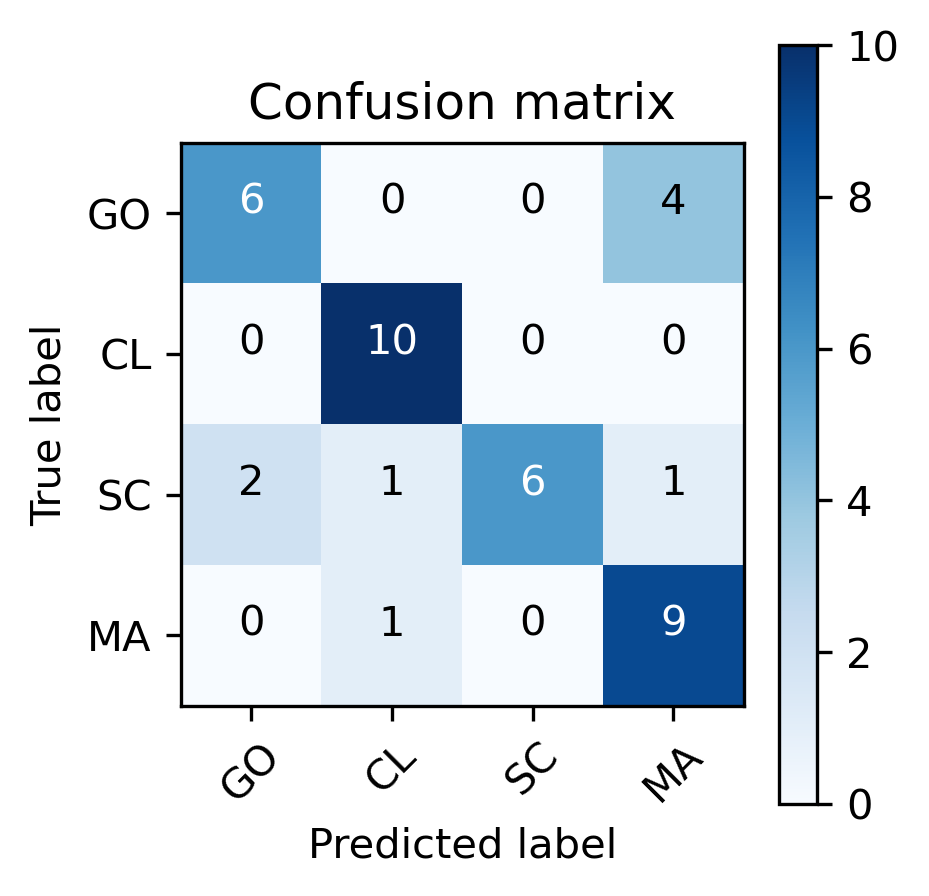

In [15]:
p_global = np.argmax(p_gh + p_br, axis=1)+3
print("Prediction branchie:", np.argmax(p_br, axis=1)+3)
print("\nPrediction ghiandola:", np.argmax(p_gh, axis=1)+3)
print("\nPrediction global:",p_global)
print("\n", "#"*50)

# True labels are:
print("\nbranchie: ", yL_br)
print("\nghiandola: ", yL_gh)

# Confusion matrix of global prediction:
print(">>> Xs18",classification_report(yL_br,p_global),
          "\nK-score=",cohen_kappa_score(yL_br,p_global),
          "\n"+"#"*10)
cnf_matrix = confusion_matrix(yL_br, p_global)
plot_cm(cnf_matrix, classes=loc_name)

# The markdown stops here.

The purpose of this markdown is to test whether we can predict the origin of clams from unpolluted areas. Hence there is no point in testing the part below (polluted vs unpolluted areas)
_____________________

In [16]:
#from sinfo import sinfo
#sinfo()

Test summing probabilities:

In [17]:
#from objbrowser import browse
#browse(pippo)